In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [41]:
# Camera calibration - Udacity code
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for cal_files in images:
    img = cv2.imread(cal_files)
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayscale, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

# camera matrix & distortion coefficient
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280), None, None)

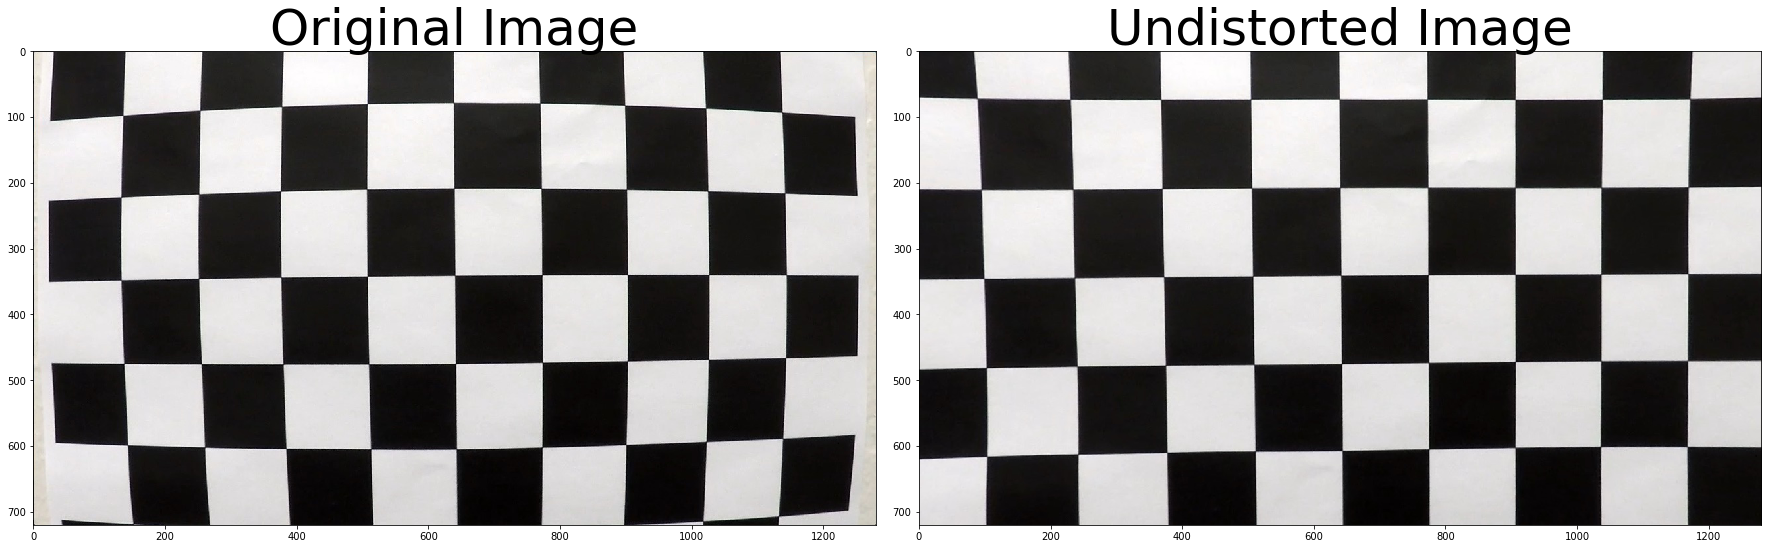

In [42]:
# Test camera distortion correction
test_img = mpimg.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
bgr = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/calibration1_undistorted.jpg', bgr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

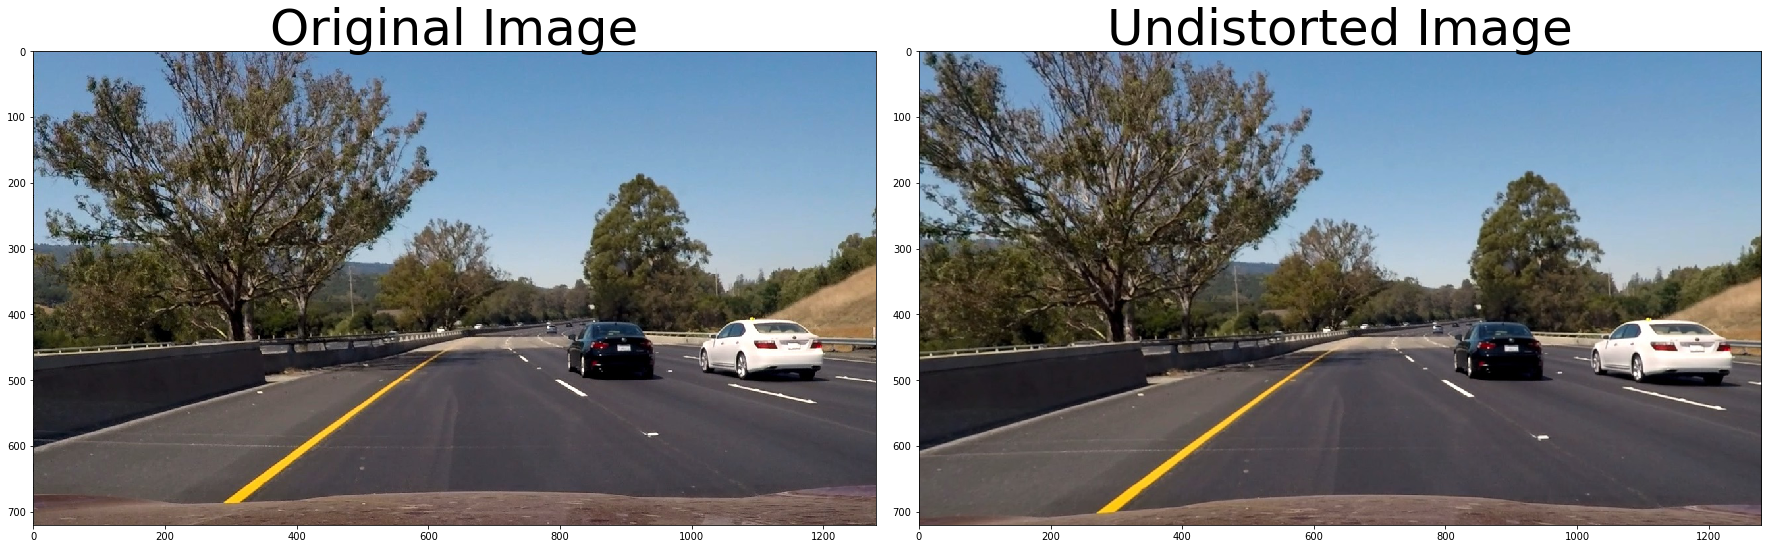

In [44]:
# Test camera distortion correction
test_img = mpimg.imread('test_images/test6.jpg')
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
bgr = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test6_undistorted.jpg', bgr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

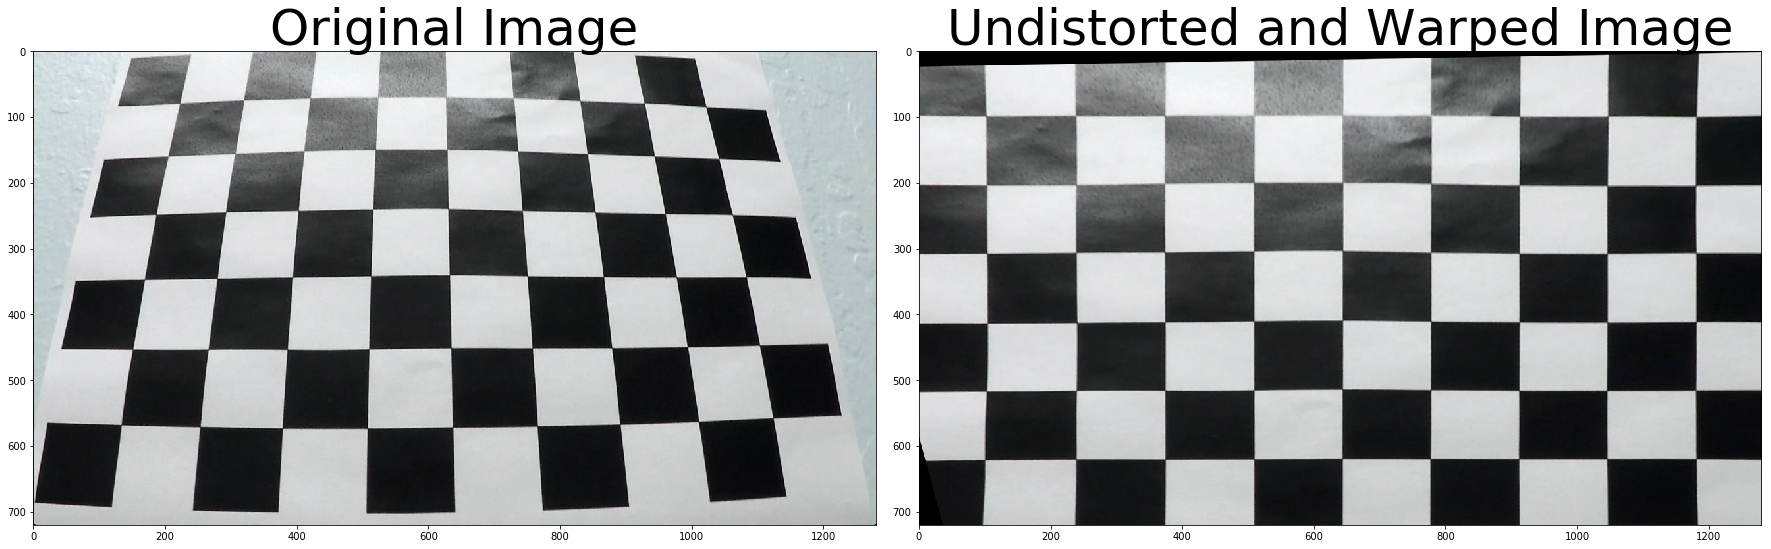

In [45]:
# Perspective transform on chess board - Udacity code

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

img = cv2.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
bgr = cv2.cvtColor(top_down, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/calibration3_topdown_perspective.jpg', bgr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

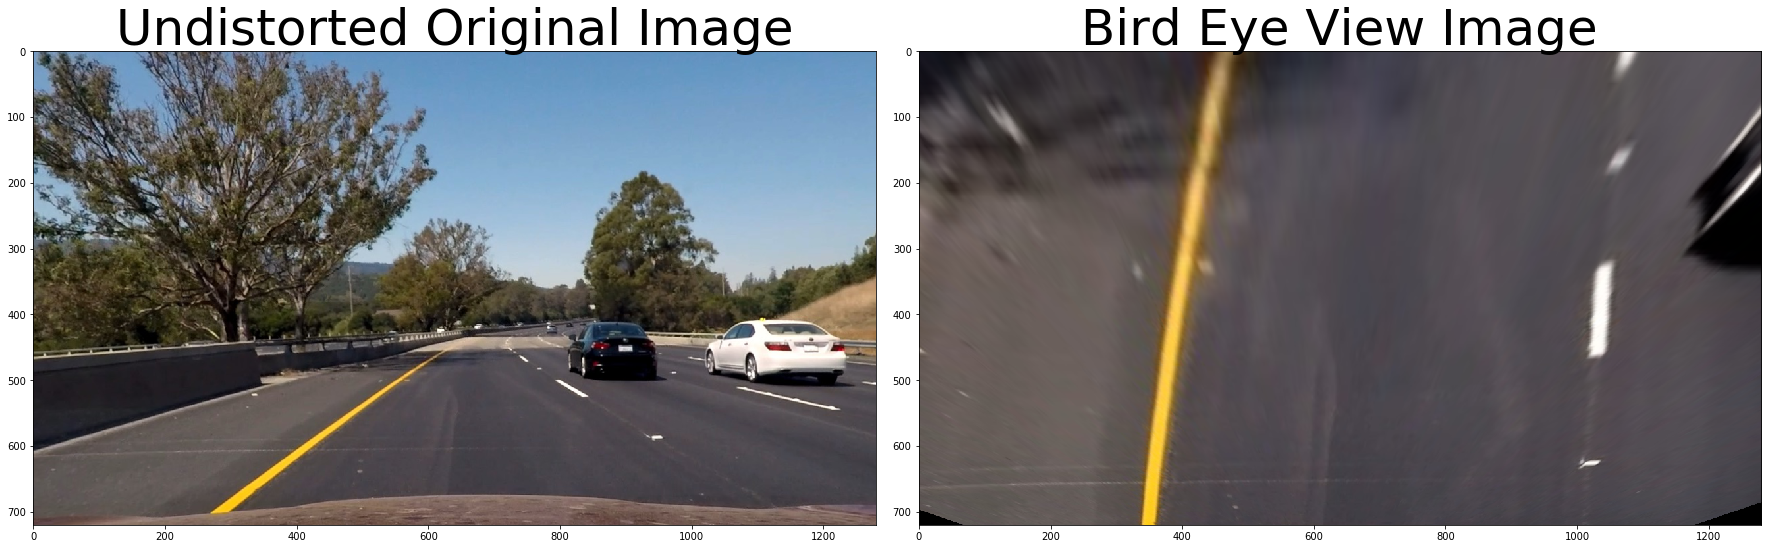

In [46]:
# Perspective transform on road images

def bird_eye_view(img):
    h, w = img.shape[0:2]

    # Define trapezoid corner pixel x & y values in straight line image
    # (290,670),(565,470),(720,470),(1030,670)
    # Lower corners are raised to prevent the hood from being mapped onto the transformed image
    src = np.float32([[290./1280*w,670./720*h], [565./1280*w,470./720*h], [720./1280*w,470./720*h], [1030./1280*w,670./720*h]])
    # Map to top down view line end points for left lane and right lane
    # (320,720),(320,0)(960,0)(960,720)
    dst = np.float32([[w/4.,h], [w/4.,0], [3.*w/4.,0], [3.*w/4.,h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    bird_eye = np.array(cv2.warpPerspective(img, M, (w, h)))

    return bird_eye, M, Minv

test_img = mpimg.imread('test_images/test6.jpg')

undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)
bgr = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test6_undistorted.jpg', bgr)

bird_eye, perspective_M, inv_perspective_M = bird_eye_view(undistorted)
bgr = cv2.cvtColor(bird_eye, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test6_birdeye.jpg', bgr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Original Image', fontsize=50)
ax2.imshow(bird_eye)
ax2.set_title('Bird Eye View Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [47]:
# Thresholded binary image - Udacity code, with modification to threshold values
def threshold_bin(img, s_thresh=(150, 255), sx_thresh=(20, 255)):
    
    img = np.copy(img)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Threshold HLS saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold sobel x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
  
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary


image = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

bird, perspective_M, inv_perspective_M = bird_eye_view(undistorted)
binary_output = threshold_bin(bird)
cv2.imwrite('output_images/test6_binary.jpg', binary_output*255)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Undistorted Image', fontsize=40)

ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 0)

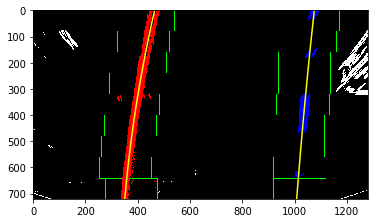

In [48]:
# Fit line polynomial - Udacity code

# Assuming you have created a warped binary image called "binary_output"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_output[binary_output.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_output, binary_output, binary_output))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_output.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_output.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_output.shape[0] - (window+1)*window_height
    win_y_high = binary_output.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_output.shape[0]-1, binary_output.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

cv2.imwrite('output_images/test6_sliding_window_visualization.jpg', out_img)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

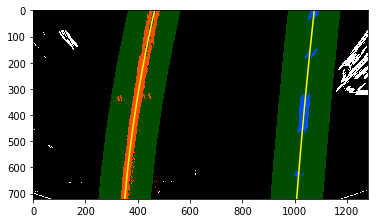

In [49]:
# Visualization - Udacity code

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_output, binary_output, binary_output))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

cv2.imwrite('output_images/test6_polynomial_fit.jpg', result)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [50]:
# Find lane curvature - Udacity code

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

5096.63427477 22125.1279151


In [53]:
# Convert radius of curvature to meters - Udacity code

# Define conversions in x and y from pixels space to meters
ym_per_pix = 3/150 # meters per pixel in y dimension
xm_per_pix = 3.7/670 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

left_curverad = int(left_curverad)
right_curverad = int(right_curverad)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

centerdist = '%.2f' % (((rightx[0] + leftx[0])/2.0 - 640)*xm_per_pix)
print (centerdist, 'm')

365 m 1589 m
0.42 m


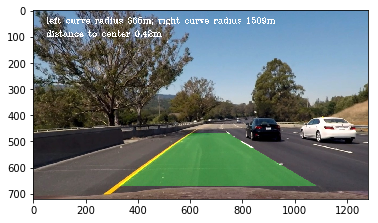

In [54]:
# Project line fit onto original image with text overlay - Udacity code with modifications

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_output).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, inv_perspective_M, (warp_zero.shape[1], warp_zero.shape[0]))
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

overlay_curve = "left curve radius " + str(left_curverad) + "m" + "; right curve radius " + str(right_curverad) + "m"
overlay_offset = "distance to center " + str(centerdist) + "m"

# use cv2.putText to overlay text with image
texted_image = cv2.putText(img=np.copy(result), text=overlay_curve, org=(50,50),fontFace=3, fontScale=1, color=(255,255,255), thickness=2)
texted_image = cv2.putText(img=np.copy(texted_image), text=overlay_offset, org=(50,100),fontFace=3, fontScale=1, color=(255,255,255), thickness=2)
bgr = cv2.cvtColor(texted_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test6_metadata_overlay.jpg', bgr)

plt.imshow(texted_image)
#plt.imshow(result)

In [ ]:
# Video pipeline - Udacity code with modification

import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define global parameters for storing line-fit polynomials, curvature and offset data to replaced "bad" frames
# Only the parameter values from the last single "good" frame is stored; the parameters are updated everytime a "good" frame is detected
first_frame = 0
left_fit_LG = None
right_fit_LG = None
left_fitx_LG = None
right_fitx_LG = None
left_curverad_LG = None
right_curverad_LG = None
centerdist_LG = None
skip_count = 0

def process_image(frame):
    # Access globally defined variables in a function
    global first_frame
    global left_fit_LG
    global right_fit_LG
    global left_fitx_LG
    global right_fitx_LG
    global left_curverad_LG
    global right_curverad_LG
    global centerdist_LG
    global skip_count

    left_fit = None
    right_fit = None
    left_fitx = None
    right_fitx = None
    left_curverad = None
    right_curverad = None
    centerdist = None
    
    undistorted = cv2.undistort(frame, mtx, dist, None, mtx)
    bird, perspective_M, inv_perspective_M = bird_eye_view(undistorted)
    binary_output = threshold_bin(bird)
    
    # if it's the first frame in the video, or if the max number of allowed frame skips has been reached
    # then run the sliding window search from scratch on the image
    if first_frame == 0 or skip_count > 15:
        # increment frame count once the first frame has been read to prevent this condition from triggering again
        first_frame += 1
        # reset skip frame counter to 0
        skip_count = 0

        histogram = np.sum(binary_output[binary_output.shape[0]//2:,:], axis=0)
        out_img = np.dstack((binary_output, binary_output, binary_output))*255
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9
        window_height = np.int(binary_output.shape[0]/nwindows)
        nonzero = binary_output.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50

        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_output.shape[0] - (window+1)*window_height
            win_y_high = binary_output.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
      
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_output.shape[0]-1, binary_output.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        y_eval = np.max(ploty)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/670 # meters per pixel in x dimension

        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        left_curverad = int(left_curverad)
        right_curverad = int(right_curverad)

        centerdist = '%.2f' % (((rightx[0] + leftx[0])/2.0 - 640)*xm_per_pix)
        
        # whenever a new frame is searched from scratch, the data becomes a new reference, or starting point for future searches
        left_fit_LG = left_fit
        right_fit_LG = right_fit
        left_fitx_LG = left_fitx
        right_fitx_LG = right_fitx
        left_curverad_LG = left_curverad
        right_curverad_LG = right_curverad
        centerdist_LG = centerdist
    # for subsequent frames, unless maximum number of frames has been skipped, use the globally stored last good polynomial fit
    # as a starting point to search for lane pixels in the current frame
    else:
        nonzero = binary_output.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # narrowly define margins to eliminate outliers that could bias line fit algorithms
        margin = 20
        # search for lane points within the band on either side of the previous polynomial fit function
        left_lane_inds = ((nonzerox > (left_fit_LG[0]*(nonzeroy**2) + left_fit_LG[1]*nonzeroy + left_fit_LG[2] - margin)) & (nonzerox < (left_fit_LG[0]*(nonzeroy**2) + left_fit_LG[1]*nonzeroy + left_fit_LG[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit_LG[0]*(nonzeroy**2) + right_fit_LG[1]*nonzeroy + right_fit_LG[2] - margin)) & (nonzerox < (right_fit_LG[0]*(nonzeroy**2) + right_fit_LG[1]*nonzeroy + right_fit_LG[2] + margin)))  
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ploty = np.linspace(0, binary_output.shape[0]-1, binary_output.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        y_eval = np.max(ploty)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/670 # meters per pixel in x dimension

        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        left_curverad = int(left_curverad)
        right_curverad = int(right_curverad)

        centerdist = '%.2f' % (((rightx[0] + leftx[0])/2.0 - 640)*xm_per_pix)
    
        # Sanity check stage - compute the maximum pixel x-coordinate deviation on either the left or right lines
        # between polynomial fit functions for the previous frame and current frame
        left_dif =  np.absolute(left_fitx - left_fitx_LG)
        right_dif = np.absolute(right_fitx - right_fitx_LG)
        
        # if the deviation exceeds a certain threshold, the frame is considered to be "bad" and skipped over
        # the line fit, curvature, offset data is replaced by last good frame (stored by global variables)
        if np.amax(left_dif) > 20 or np.amax(right_dif) > 20:
            skip_count += 1

            left_fitx = left_fitx_LG
            right_fitx = right_fitx_LG
            left_curverad = left_curverad_LG
            right_curverad = right_curverad_LG
            centerdist = centerdist_LG
        # if the new polynomial fit lines are within reasonable threshold from previous frame, the new frame data is valid
        else:
            # reset skip frame counter, as current frame is a "good" frame
            skip_count = 0
            
            # update global parameters with data from current frame, it is now the latest reference for start of search in next frame
            left_fit_LG = left_fit
            right_fit_LG = right_fit
            left_fitx_LG = left_fitx
            right_fitx_LG = right_fitx
            left_curverad_LG = left_curverad
            right_curverad_LG = right_curverad
            centerdist_LG = centerdist

    warp_zero = np.zeros_like(binary_output).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, inv_perspective_M, (warp_zero.shape[1], warp_zero.shape[0]))
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    overlay_curve = "left curve radius " + str(left_curverad) + "m" + "; right curve radius " + str(right_curverad) + "m"
    overlay_offset = "distance to center " + str(centerdist) + "m"

    texted_image = cv2.putText(img=np.copy(result), text=overlay_curve, org=(50,50),fontFace=3, fontScale=1, color=(255,255,255), thickness=2)
    texted_image = cv2.putText(img=np.copy(texted_image), text=overlay_offset, org=(50,100),fontFace=3, fontScale=1, color=(255,255,255), thickness=2)

    return texted_image

# extract frame from video, output new video with lane tracking mask and metadata overlay
project_output = 'output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(project_output, audio=False)